In [1]:
import cv2 
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

torch.set_default_tensor_type('torch.DoubleTensor')

In [14]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


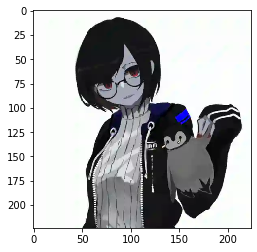

In [3]:
image = cv2.imread(os.path.join("C:/Users/ericp/Desktop/pixiv/data/normal/", "72390335_p0_square1200.jpg"))
image = cv2.resize(image, (224,224)) 
plt.imshow(image)

In [4]:
images_n = []
for file in os.listdir("C:/Users/ericp/Desktop/pixiv/data/normal"):
    image = cv2.imread(os.path.join("C:/Users/ericp/Desktop/pixiv/data/normal", file))
    image = cv2.resize(image, (224, 224)) 
    #blue_image = image[:,:,0]
    #green_image = image[:,:,1]
    #red_image = image[:,:,2]
    images_n.append(list((np.transpose(image)/255.0).astype('float64')))
images_n = np.array(images_n)
print(images_n.shape)

(7207, 3, 224, 224)


In [5]:
images_r = []
for file in os.listdir("C:/Users/ericp/Desktop/pixiv/data/r18"):
    image = cv2.imread(os.path.join("C:/Users/ericp/Desktop/pixiv/data/r18", file))
    image = cv2.resize(image, (224, 224)) 
    #blue_image = image[:,:,0]
    #green_image = image[:,:,1]
    #red_image = image[:,:,2]
    images_r.append(list((np.transpose(image)/255.0).astype('float64')))
images_r = np.array(images_r)
print(images_r.shape)

(3687, 3, 224, 224)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((images_n, images_r), axis = 0), 
    np.concatenate((np.zeros(len(images_n)).astype('float64'), np.ones(len(images_r)).astype('float64')), axis = 0), 
    test_size=0.33)

In [7]:
class OurDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = torch.from_numpy(self.X[idx])
        label = torch.tensor(self.Y[idx], dtype=torch.long) 
        
        if self.transform:
            item = self.transform(item)
        
        return (item, label)

In [8]:
trainData = OurDataset(X_train,  y_train)
testData = OurDataset(X_test,  y_test)
trainLoader = DataLoader(trainData, batch_size=128, shuffle=True, num_workers=0)
testLoader = DataLoader(testData, batch_size=128, shuffle=False, num_workers=0)

In [17]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
net = VGG(make_layers(cfgs['D']))

optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=0)
optimizer.zero_grad()

criterion = nn.CrossEntropyLoss()

def test(net, testLoader):
    net.eval()
    correct = 0
    with torch.no_grad():
        for (data,target) in testLoader:
            output = net(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        print("Test Accuracy: %f" % (100.*correct/len(testLoader.dataset)))

test(net, testLoader)

for epoch in range(10):
    net.train()
    for batch_idx, (data, target) in enumerate(trainLoader):
        pred = net(data)
        loss = criterion(pred, target)
        loss.backward()
        gn = 0
        for f in net.parameters():
            gn = gn + torch.norm(f.grad)
        print("E: %d; B: %d; Loss: %f; ||g||: %f" % (epoch, batch_idx, loss, gn))
        optimizer.step()
        optimizer.zero_grad()
    
    test(net, testLoader)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 29595009024 bytes. Buy new RAM!
